In [1]:
import arviz as az
import numpy as np
import random
import os
import sys
import matplotlib.pyplot as plt

"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def formalize_array(x, step, slice_len, skip, sliding_window=True):
    if sliding_window:
        N = int(np.floor((x.shape[0]-slice_len*step+1)/skip))
        x_all = np.zeros((N,slice_len))
        for i in range(N):
            x_all[i,:] = x[i*skip:i*skip+slice_len*step:step]
    else:
        x = x[0: -1: step]
        N = int(np.floor(x.shape[0]/slice_len))
        x_all = np.zeros((N,slice_len))
        for i in range(N):
            x_all[i,:] = x[slice_len*i:slice_len*(i+1)]
    return x_all

def load_training_data(base_path, step, min_traj_lenth, skip, pair_id_list):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    
    slice_len=int(3/(step*Config.dt))
    pair_id = pair_id_list
    vt = formalize_array(tracks[pair_id]['vFollReal'], step, slice_len, skip)
    s = formalize_array(tracks[pair_id]['sReal'], step, slice_len, skip)
    dv = formalize_array(tracks[pair_id]['dvReal'], step, slice_len, skip)
    label_v = formalize_array(tracks[pair_id]['vFollReal_next'], step, slice_len, skip)
    
    print("Traj lenth:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return vt, s, dv, label_v

def GP_IDM_pool(base_path, step):
    # load interactive data for car
    vt, s, dv, label_v = load_training_data(base_path, step, min_traj_lenth=50/Config.dt,
                                           skip=20, pair_id_list=Config.truck_interactive_pair_list[0])
    
    print("training size:", label_v.shape)
    
    dt = Config.dt

    model = pm.Model()

    D = 5
    
    slice_len=int(3/(step*Config.dt))
    GP_t = np.array(range(slice_len*step))[0:-1:step].reshape(-1,1)
    shh = GP_t.shape[0]
    
    with model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * tt.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * Config.dt
        
        s_ = pm.ConstantData("s", s)
        vt_ = pm.ConstantData("vt", vt)
        dv_ = pm.ConstantData("dv", dv)
        
        mu_prior = pm.floatX(np.array([0,0,0,0,0]))
        parameters_normalized = pm.MvNormal('mu_normalized', mu_prior, chol=np.eye(D))
        
        log_parameters = pm.Deterministic('log_mu', parameters_normalized*np.array([.3, 1., 1., .5, .5])
                                      +np.array([2., 0.69, 0.47, -.3, .51]))
        
        parameters = pm.Deterministic('mu', tt.exp(log_parameters))
        
        DELTA = 4 
        
        #################################################
        # priors on the covariance function hyperparameters
        l = pm.Normal('l', mu=35, sigma=10)
        # Normal prior on the function variance
        s2_f = pm.Normal('s2_f', mu=0.01, sigma=0.001)
        #################################################
       
        log_s2_v = pm.Uniform('log_s2_v', lower=-8.0, upper=-4.0)
        s2_v = pm.Deterministic('s2_v', tt.exp(log_s2_v))
        
        # covariance functions for the function f and the noise
        cov_func = pm.gp.cov.ExpQuad(1, l)
        cov_obs = dt**2 * (s2_f* cov_func(GP_t)+ s2_v*tt.eye(shh))
        
        v_obs = pm.MvNormal('obs', mu=IDM_v(parameters[0], parameters[1], parameters[2], parameters[3],
                                            parameters[4],DELTA, s_, vt_, dv_), cov=cov_obs, observed=label_v)
        
        tr = pm.sample(draws=10000, tune=10000, random_seed=16, init='jitter+adapt_diag_grad', chains=1,
                       cores=8, discard_tuned_samples=True, return_inferencedata=True, target_accept=0.90)
    return tr, model

In [3]:
base_path = '../data/highD/'
step = 2
tr, model = GP_IDM_pool(base_path, step)

Traj lenth: 50.0 , ID list: 5 , Data size: (76, 37)
training size: (76, 37)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_normalized, l, s2_f, log_s2_v]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 632 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [3]:
import pickle
from pickle import UnpicklingError
base_path = '../data/highD/'
step = 2

cache = "../PGM/cache/GP_IDM_unpooled_truck-exp.pkl"
if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

Load trace ../PGM/cache/GP_IDM_unpooled_truck-exp.pkl : done!


In [4]:
print(np.sqrt(tr.posterior.s2_v.mean(axis=0).mean(axis=0)))
print(np.sqrt(tr.posterior.s2_f.mean(axis=0).mean(axis=0)))

<xarray.DataArray 's2_v' ()>
array(0.10152267)
<xarray.DataArray 's2_f' ()>
array(0.13701179)


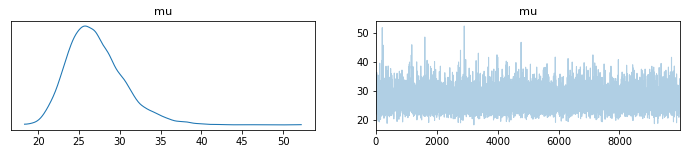

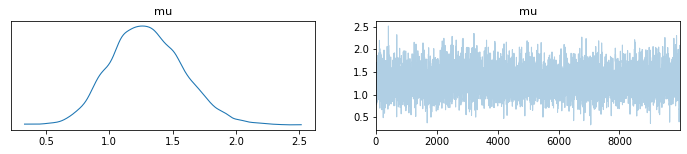

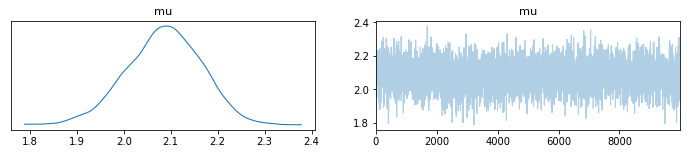

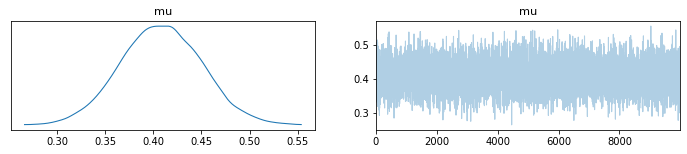

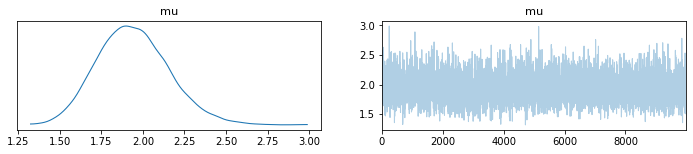

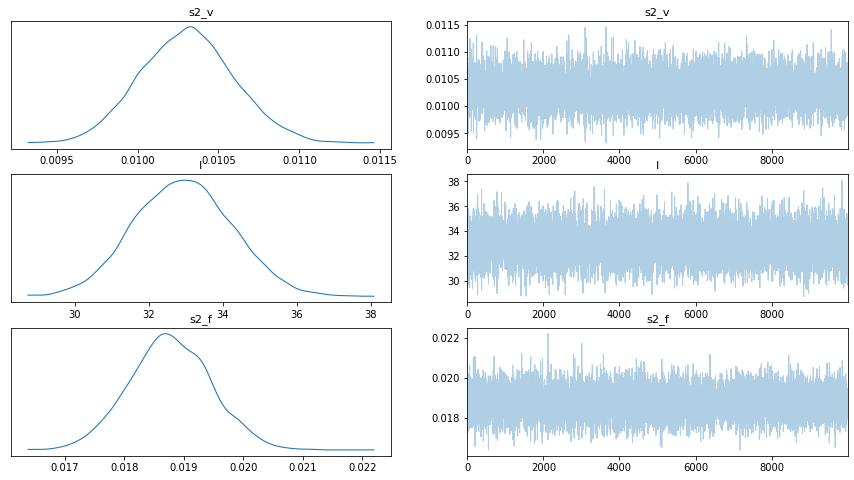

In [6]:
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":0},compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":1}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":2}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":3}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":4}, compact=True)
# _ = az.plot_trace(tr, var_names=["alpha"], compact=True)
_ = az.plot_trace(tr, var_names=["s2_v","l","s2_f"],figsize=(15,8), compact=True)

In [6]:
az.summary(tr, var_names=["mu","log_mu","s2_v", "l", "s2_f"])

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],27.059,3.490,21.064,33.711,0.038,0.027,9542.0,6929.0,NaN
mu[1],1.294,0.286,0.778,1.842,0.005,0.004,2800.0,4440.0,NaN
mu[2],2.086,0.079,1.941,2.236,0.002,0.001,2753.0,3749.0,NaN
mu[3],0.408,0.042,0.331,0.488,0.001,0.000,4850.0,5206.0,NaN
mu[4],1.942,0.215,1.532,2.334,0.004,0.003,2968.0,3600.0,NaN
log_mu[0],3.290,0.125,3.067,3.534,0.001,0.001,9542.0,6929.0,NaN
log_mu[1],0.232,0.231,-0.178,0.654,0.004,0.003,2800.0,4440.0,NaN
log_mu[2],0.735,0.038,0.663,0.805,0.001,0.001,2753.0,3749.0,NaN
log_mu[3],-0.902,0.103,-1.101,-0.712,0.001,0.001,4850.0,5206.0,NaN
log_mu[4],0.657,0.111,0.454,0.869,0.002,0.001,2968.0,3600.0,NaN


In [5]:
32.938 * Config.dt

1.31752

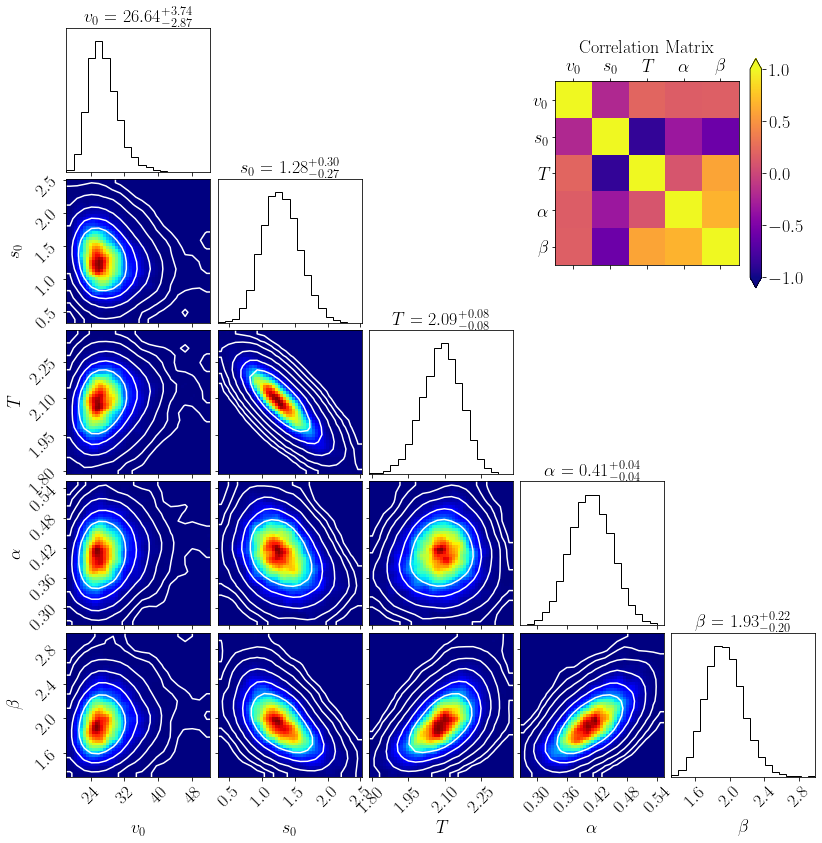

In [4]:
import corner
import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure = corner.corner(
    tr,
    var_names=['mu'],
    smooth=1.,
    color = 'k',
    plot_contours=True,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu[0,:,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

figure.savefig('../Figs/GP_IDM_unpool_truck.pdf', dpi=300)

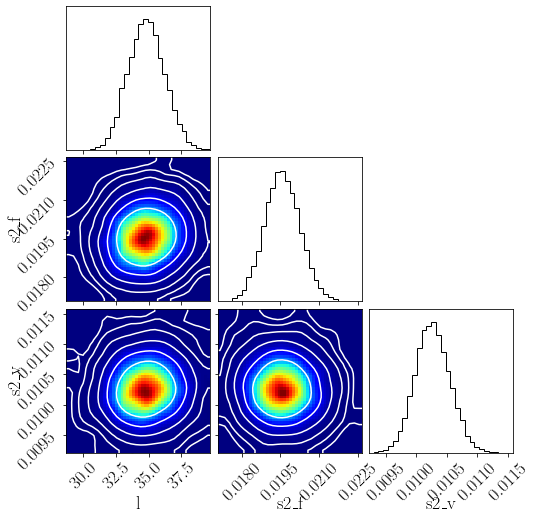

In [10]:
# import corner

_ = corner.corner(
    tr,
    smooth=1.5,
    bins=30,
    var_names=["l", "s2_f", "s2_v"]
)

In [10]:
az.waic(tr)

Computed from 20000 posterior samples and 2577 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 372620.69   284.29
p_waic       20.62        -

There has been a warning during the calculation. Please check the results.